In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Dense EncoderDecoder

## Installations

In [2]:
# requirements = """
# keras
# git+https://www.github.com/keras-team/keras-contrib.git
# matplotlib
# numpy
# scipy
# pillow
# #urllib
# #skimage
# scikit-image
# #gzip
# #pickle
# """
# %store requirements > requirements.txt

In [3]:
# !pip install -r requirements.txt

## Import TensorFlow and other libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


## Load the dataset

Steps to generate URL used below:
- Say, your data files are in the directory called 'input'
- Manually create a zip file, 'input.zip'
- Sync it to gDrive
- In gDrive, Share it with Public model, copy its share-able link
- Use https://sites.google.com/site/gdocs2direct/ to generate corresponding Direct link
- Paste it below

In [5]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = "D:/Yogesh/ToDos/Research/MidcurveNN/code/data/input"

In [6]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [7]:
def get_training_data(datafolder = input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [8]:
profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [9]:
def plot_results(original_imgs,computed_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

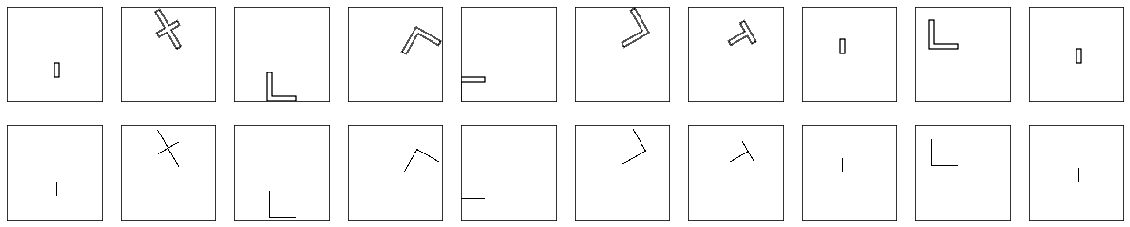

In [10]:
plot_results(profile_pngs_objs,midcurve_pngs_objs)

In [11]:
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from prepare_data import get_training_data
from prepare_plots import plot_results
import numpy as np
import os
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

class dense_encoderdecoder:
    def __init__(self):
        self.encoding_dim = 100
        self.input_dim = 10000
        self.epochs = 50
        self.autoencoder_model_pkl = "models/dense_autoencoder_model.pkl"
        self.encoder_model_pkl = "models/dense_encoder_model.pkl"
        self.decoder_model_pkl = "models/dense_decoder_model.pkl"
                
    def process_images(self,grayobjs):
        flat_objs = [x.reshape(self.input_dim) for x in grayobjs]
        pngs_objs = np.array(flat_objs)
        return pngs_objs

    def train(self,
            profile_pngs_gray_objs, 
            midcurve_pngs_gray_objs):
        if not os.path.exists(self.autoencoder_model_pkl):        
            # this is our input placeholder
            input_img = Input(shape=(self.input_dim,))
            
            # "encoded" is the encoded representation of the input
            encoded = Dense(self.input_dim, activation='relu')(input_img)
            encoded = Dense(self.input_dim, activation='relu')(encoded)
            encoded = Dense(self.encoding_dim, activation='relu')(encoded)
            
            # "decoded" is the lossy reconstruction of the input
            decoded = Dense(self.encoding_dim, activation='relu')(encoded)
            decoded = Dense(self.input_dim, activation='relu')(decoded)
            decoded = Dense(self.input_dim, activation='sigmoid')(decoded) 
            
            # Model 1: Full AutoEncoder, includes both encoder single dense layer and decoder single dense layer. 
            # This model maps an input to its reconstruction
            self.autoencoder = Model(input_img, decoded)
                    
            # Model 2: a separate encoder model: -------------------
            # this model maps an input to its encoded representation
            self.encoder = Model(input_img, encoded)
            
            # Model 3: a separate encoder model: -------------------
            # create a placeholder for an encoded (32-dimensional) input
            encoded_input = Input(shape=(self.encoding_dim,))
            # retrieve the last to last layer of the autoencoder model
            decoder_layer = self.autoencoder.layers[-2]
            # create the decoder model
            self.decoder = Model(encoded_input, decoder_layer(encoded_input))            
                    
            # Compilation of Autoencoder (only)
            self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
                
#             # Training
#             profile_pngs_flat_objs = [x.reshape(input_dim) for x in profile_pngs_gray_objs]
#             midcurve_pngs_flat_objs = [x.reshape(input_dim) for x in midcurve_pngs_gray_objs]
#              
#             profile_pngs_objs = np.array(profile_pngs_flat_objs)
#             midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
        
            profile_pngs_objs = self.process_images(profile_pngs_gray_objs)
            midcurve_pngs_objs = self.process_images(midcurve_pngs_gray_objs)
                    
#             train_size = int(len(profile_pngs_objs)*0.7)
#             self.x_train = profile_pngs_objs[:train_size]
#             self.y_train = midcurve_pngs_objs[:train_size]
#             self.x_test = profile_pngs_objs[train_size:]
#             self.y_test = midcurve_pngs_objs[train_size:]
#             self.autoencoder.fit(self.x_train, self.y_train,
#                         epochs=self.epochs,
#                         batch_size=32,
#                         shuffle=True,
#                         validation_data=(self.x_test, self.y_test))
                
            self.x = profile_pngs_objs
            self.y = midcurve_pngs_objs
            self.autoencoder.fit(self.x, self.y,
                        epochs=self.epochs,
                        batch_size=5,
                        shuffle=True)                     
            # Save models
            self.autoencoder.save(self.autoencoder_model_pkl)
            self.encoder.save(self.encoder_model_pkl)
            self.decoder.save(self.decoder_model_pkl)  
        else:
            # Save models
            self.autoencoder = load_model(self.autoencoder_model_pkl)
            self.encoder= load_model(self.encoder_model_pkl)
            self.decoder = load_model(self.decoder_model_pkl)
    
    def predict(self, test_profile_images):
        png_profile_images = self.process_images(test_profile_images)
        encoded_imgs = self.encoder.predict(png_profile_images)
        decoded_imgs = self.decoder.predict(encoded_imgs)    
        return test_profile_images,decoded_imgs  
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 313 samples, validate on 135 samples
Epoch 1/200
313/313 [==============================] - 22s 70ms/step - loss: -1.5044 - val_loss: -7.5012
Epoch 2/200
313/313 [==============================] - 5s 16ms/step - loss: -11.7198 - val_loss: -11.4209
Epoch 3/200
313/313 [==============================] - 5s 17ms/step - loss: -14.4688 - val_loss: -12.5595
Epoch 4/200
313/313 [==============================] - 6s 19ms/step - loss: -15.4638 - val_loss: -12.9301
Epoch 5/200
313/313 [==============================] - 7s 21ms/step - loss: -15.9656 - val_loss: -12.9418
Epoch 6/200
313/313 [==============================] - 5s 15ms/step - loss: -16.2564 - val_loss: -12.7942
Epoch 7/200
313/313 [==============================] - 5s 16ms/step - loss: -16.4430 - val_loss: -12.7900
Epoch 8/200
313/313 [==============================] - 6s 18ms/step - loss: -16.5942 - val_lo

Epoch 72/200
313/313 [==============================] - 4s 14ms/step - loss: -17.3585 - val_loss: -9.5635
Epoch 73/200
313/313 [==============================] - 5s 17ms/step - loss: -17.3720 - val_loss: -9.5186
Epoch 74/200
313/313 [==============================] - 6s 18ms/step - loss: -17.3628 - val_loss: -9.6707
Epoch 75/200
313/313 [==============================] - 5s 15ms/step - loss: -17.3748 - val_loss: -9.5398
Epoch 76/200
313/313 [==============================] - 5s 15ms/step - loss: -17.3718 - val_loss: -9.6795
Epoch 77/200
313/313 [==============================] - 5s 16ms/step - loss: -17.3703 - val_loss: -9.5904
Epoch 78/200
313/313 [==============================] - 5s 16ms/step - loss: -17.3792 - val_loss: -9.5361
Epoch 79/200
313/313 [==============================] - 5s 15ms/step - loss: -17.3823 - val_loss: -9.5501
Epoch 80/200
313/313 [==============================] - 5s 16ms/step - loss: -17.3978 - val_loss: -9.5911
Epoch 81/200
313/313 [========================

Epoch 149/200
313/313 [==============================] - 5s 15ms/step - loss: -17.5321 - val_loss: -8.3258
Epoch 150/200
313/313 [==============================] - 5s 15ms/step - loss: -17.5283 - val_loss: -8.2927
Epoch 151/200
313/313 [==============================] - 5s 15ms/step - loss: -17.5288 - val_loss: -8.2847
Epoch 152/200
313/313 [==============================] - 5s 16ms/step - loss: -17.5361 - val_loss: -8.3022
Epoch 153/200
313/313 [==============================] - 7s 24ms/step - loss: -17.5392 - val_loss: -8.3994
Epoch 154/200
313/313 [==============================] - 6s 18ms/step - loss: -17.5360 - val_loss: -8.3178
Epoch 155/200
313/313 [==============================] - 6s 21ms/step - loss: -17.5372 - val_loss: -8.2599
Epoch 156/200
313/313 [==============================] - 5s 17ms/step - loss: -17.5389 - val_loss: -8.2783
Epoch 157/200
313/313 [==============================] - 6s 20ms/step - loss: -17.5471 - val_loss: -8.3249
Epoch 158/200
313/313 [==============

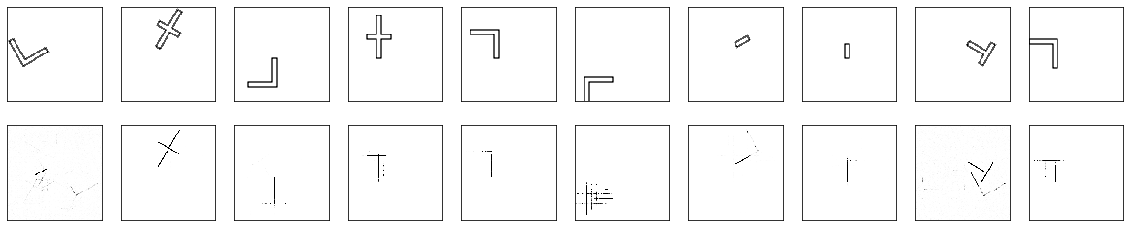

In [12]:
profile_gray_objs, midcurve_gray_objs = get_training_data()
endec = dense_encoderdecoder()
endec.train(profile_gray_objs, midcurve_gray_objs)

test_gray_images = random.sample(profile_gray_objs,5)
original_profile_imgs,predicted_midcurve_imgs = endec.predict(test_gray_images)
plot_results(original_profile_imgs,predicted_midcurve_imgs)